## Trabalho 04 — INFO7017 IA
LSTM
  Alunos:
   - Fabiane Sorbar
   - Vinicius Tessele       

**Trate os valores ausentes.**
- Faça a união das colunas year, month, day e hour em um datetime.
- Normalize as variáveis de entrada.
- Crie janelas temporais (ex: últimas 24 horas A prever PM2.5 da próxima hora).
- Utilize como entrada os dados metereológicos combinados com a hora do dia.
- Modele uma arquitetura: Dense (64) A Dense (32) A Dense (1).
- Avalie o modelo com as métrias de regressão MAE, RMSE e R2.
- Plote uma curva real x predito em um dado intervalo (p. ex., uma semana).

In [5]:
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# special style template for matplotlib, highly useful for visualizing time series data
plt.style.use("fivethirtyeight")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD

In [24]:
dados = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv'
df = pd.read_csv(dados)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43824 entries, 0 to 43823
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   year    43824 non-null  int64  
 2   month   43824 non-null  int64  
 3   day     43824 non-null  int64  
 4   hour    43824 non-null  int64  
 5   pm2.5   41757 non-null  float64
 6   DEWP    43824 non-null  int64  
 7   TEMP    43824 non-null  float64
 8   PRES    43824 non-null  float64
 9   cbwd    43824 non-null  object 
 10  Iws     43824 non-null  float64
 11  Is      43824 non-null  int64  
 12  Ir      43824 non-null  int64  
dtypes: float64(4), int64(8), object(1)
memory usage: 4.3+ MB


In [41]:
print(df.shape)
df.head(5)


(43824, 13)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
datetime,,,,,,,,,,,,,
2010-01-01 00:00:00,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [31]:
df['datetime'] = pd.to_datetime(df[['year', 'month', 'day', 'hour']])
df = df.sort_values('datetime')
df = df.set_index('datetime')

In [27]:
print(df.isnull().sum())

# Percentual de dados faltantes por coluna
print((df.isnull().sum() / len(df)) * 100)

No             0
year           0
month          0
day            0
hour           0
pm2.5       2067
DEWP           0
TEMP           0
PRES           0
cbwd           0
Iws            0
Is             0
Ir             0
datetime       0
dtype: int64
No          0.000000
year        0.000000
month       0.000000
day         0.000000
hour        0.000000
pm2.5       4.716594
DEWP        0.000000
TEMP        0.000000
PRES        0.000000
cbwd        0.000000
Iws         0.000000
Is          0.000000
Ir          0.000000
datetime    0.000000
dtype: float64


In [28]:
print(df['pm2.5'].isnull().sum())     # quantos NaN
print((df['pm2.5'] < 0).sum())        # quantos negativos


2067
0


In [34]:
# 1. Remove linhas com pm2.5 ausente
df_dropna = df.dropna(subset=['pm2.5'])

# 2. Interpolação temporal - índice deve ser DatetimeIndex
df_fill_interp = df.copy()
df_fill_interp['pm2.5'] = df_fill_interp['pm2.5'].interpolate(method='time')

# 3. Preencher NaN com forward fill
df_fill_ffill = df.copy()
df_fill_ffill['pm2.5'] = df_fill_ffill['pm2.5'].ffill()

print("NaNs após remover: ", df_dropna['pm2.5'].isnull().sum())
print("NaNs após fillna forward fill: ", df_fill_ffill['pm2.5'].isnull().sum())
print("NaNs após interpolação temporal: ", df_fill_interp['pm2.5'].isnull().sum())

NaNs após remover:  0
NaNs após fillna forward fill:  24
NaNs após interpolação temporal:  24


In [37]:
print(df_fill_interp[df_fill_interp['pm2.5'].isnull()])

                     No  year  month  day  hour  pm2.5  DEWP  TEMP    PRES  \
datetime                                                                     
2010-01-01 00:00:00   1  2010      1    1     0    NaN   -21 -11.0  1021.0   
2010-01-01 01:00:00   2  2010      1    1     1    NaN   -21 -12.0  1020.0   
2010-01-01 02:00:00   3  2010      1    1     2    NaN   -21 -11.0  1019.0   
2010-01-01 03:00:00   4  2010      1    1     3    NaN   -21 -14.0  1019.0   
2010-01-01 04:00:00   5  2010      1    1     4    NaN   -20 -12.0  1018.0   
2010-01-01 05:00:00   6  2010      1    1     5    NaN   -19 -10.0  1017.0   
2010-01-01 06:00:00   7  2010      1    1     6    NaN   -19  -9.0  1017.0   
2010-01-01 07:00:00   8  2010      1    1     7    NaN   -19  -9.0  1017.0   
2010-01-01 08:00:00   9  2010      1    1     8    NaN   -19  -9.0  1017.0   
2010-01-01 09:00:00  10  2010      1    1     9    NaN   -20  -8.0  1017.0   
2010-01-01 10:00:00  11  2010      1    1    10    NaN   -19  -7

In [38]:
df_fill_interp = df_fill_interp.dropna(subset=['pm2.5'])

In [39]:
df_fill_ffill = df_fill_ffill.dropna(subset=['pm2.5'])

In [40]:
print("NaNs após remover: ", df_dropna['pm2.5'].isnull().sum())
print("NaNs após fillna forward fill: ", df_fill_ffill['pm2.5'].isnull().sum())
print("NaNs após interpolação temporal: ", df_fill_interp['pm2.5'].isnull().sum())

NaNs após remover:  0
NaNs após fillna forward fill:  0
NaNs após interpolação temporal:  0


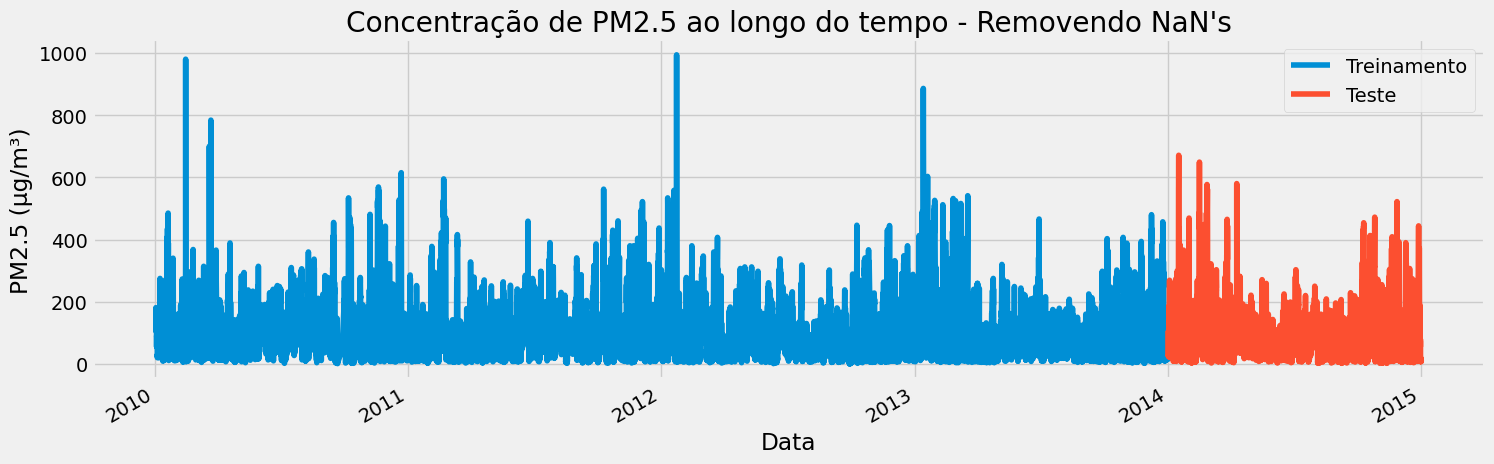

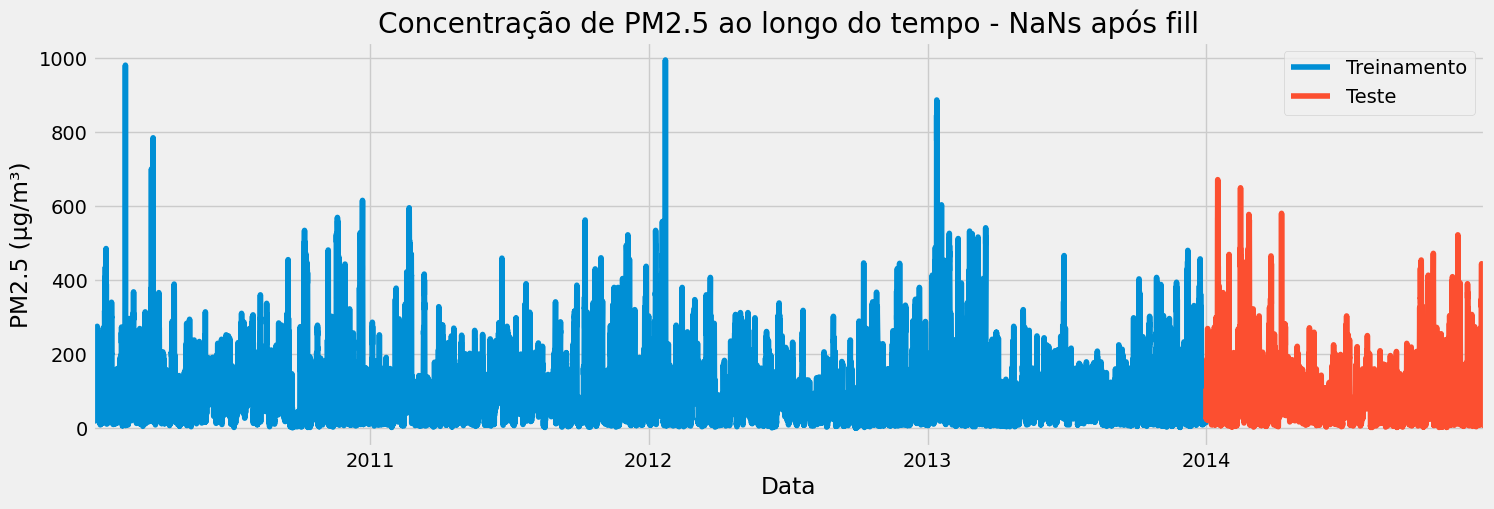

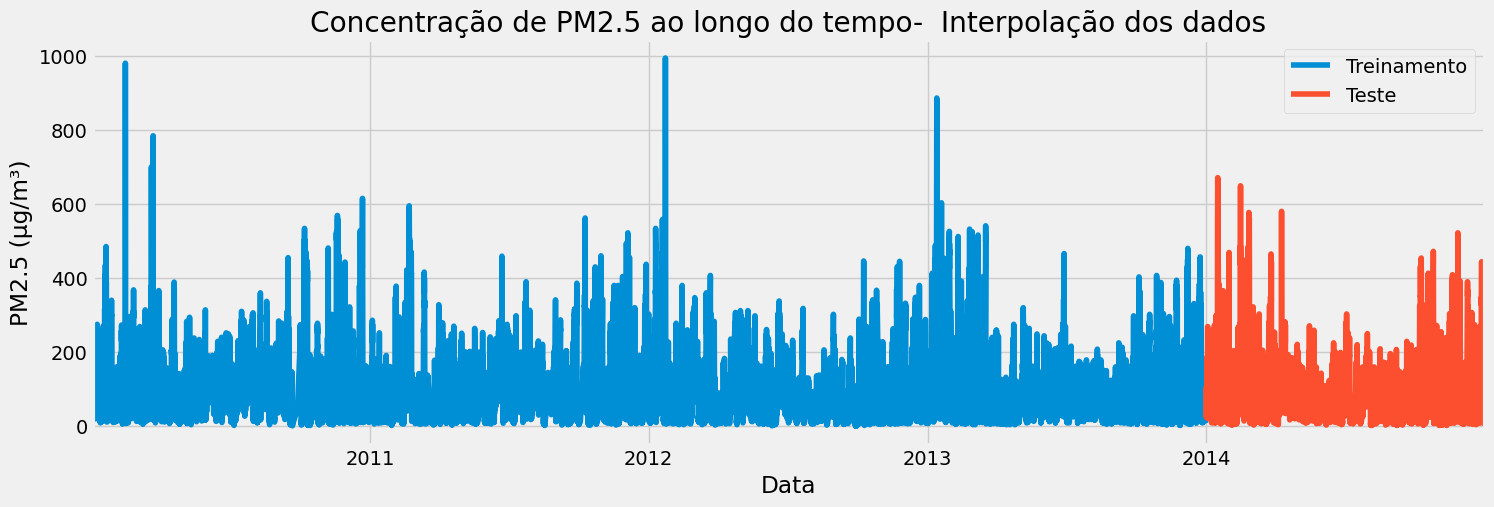

In [47]:
#Removendo NaN's
df_dropna = df_dropna.sort_index()

# Conjuntos de treino e teste: por exemplo, treino até 2013, teste a partir de 2014
train_set = df_dropna['pm2.5']['2010':'2013']
test_set = df_dropna['pm2.5']['2014':]

plt.figure(figsize=(16, 5))

train_set.plot(label="Treinamento")
test_set.plot(label="Teste")

plt.title("Concentração de PM2.5 ao longo do tempo - Removendo NaN's")
plt.xlabel("Data")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True)
plt.show()

#NaNs após fill
df_fill_ffill = df_fill_ffill.sort_index()  # já está com datetime como índice

# Conjuntos de treino e teste: por exemplo, treino até 2013, teste a partir de 2014
train_setfill = df_fill_ffill['pm2.5']['2010':'2013']
test_setfill = df_fill_ffill['pm2.5']['2014':]

plt.figure(figsize=(16, 5))

train_setfill.plot(label="Treinamento")
test_setfill.plot(label="Teste")

plt.title("Concentração de PM2.5 ao longo do tempo - NaNs após fill")
plt.xlabel("Data")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True)
plt.show()

#Interpolação dos dados
df_fill_interp = df_fill_interp.sort_index()  # já está com datetime como índice

# Conjuntos de treino e teste: por exemplo, treino até 2013, teste a partir de 2014
train_setInter = df_fill_interp['pm2.5']['2010':'2013']
test_setInter = df_fill_interp['pm2.5']['2014':]

plt.figure(figsize=(16, 5))

train_setInter.plot(label="Treinamento")
test_setInter.plot(label="Teste")

plt.title("Concentração de PM2.5 ao longo do tempo-  Interpolação dos dados")
plt.xlabel("Data")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend()
plt.grid(True)
plt.show()

In [54]:
df_dropna = df_dropna[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws']]  # selecione colunas úteis

scaler = MinMaxScaler()
training_set_scaleddropna = pd.DataFrame(scaler.fit_transform(df_dropna), columns=df_dropna.columns, index=df_dropna.index)

print(f"Training set scaled - dropna: {training_set_scaleddropna.shape}")
print(f"First 3 rows:\n{training_set_scaleddropna[0:3]}\n")

df_fill_ffill = df_fill_ffill[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws']]  # selecione colunas úteis

scaler = MinMaxScaler()
training_set_scaledfill = pd.DataFrame(scaler.fit_transform(df_fill_ffill), columns=df_fill_ffill.columns, index=df_fill_ffill.index)

print(f"Training set scaled - fill: {training_set_scaledfill.shape}")
print(f"First 3 rows:\n{training_set_scaledfill[0:3]}\n")

df_fill_interp = df_fill_interp[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws']]  # selecione colunas úteis

scaler = MinMaxScaler()
training_set_scaledinterp = pd.DataFrame(scaler.fit_transform(df_fill_interp), columns=df_fill_interp.columns, index=df_fill_interp.index)

print(f"Training set scaled - interp: {training_set_scaledinterp.shape}")
print(f"First 3 rows:\n{training_set_scaledinterp[0:3]}\n")

Training set scaled - dropna: (41757, 5)
First 3 rows:
                        pm2.5      DEWP      TEMP      PRES       Iws
datetime                                                             
2010-01-02 00:00:00  0.129779  0.352941  0.245902  0.527273  0.002372
2010-01-02 01:00:00  0.148893  0.367647  0.245902  0.527273  0.003947
2010-01-02 02:00:00  0.159960  0.426471  0.229508  0.545455  0.005522

Training set scaled - fill: (43800, 5)
First 3 rows:
                        pm2.5      DEWP      TEMP      PRES       Iws
datetime                                                             
2010-01-02 00:00:00  0.129779  0.352941  0.245902  0.527273  0.002290
2010-01-02 01:00:00  0.148893  0.367647  0.245902  0.527273  0.003811
2010-01-02 02:00:00  0.159960  0.426471  0.229508  0.545455  0.005332

Training set scaled - interp: (43800, 5)
First 3 rows:
                        pm2.5      DEWP      TEMP      PRES       Iws
datetime                                                         

In [56]:
def create_windowed_dataset(data, window_size=24):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, 0])  # pm2.5 é a primeira coluna
    return np.array(X), np.array(y)


In [61]:
data_dropna = training_set_scaleddropna.values  # convert DataFrame to numpy array

X_dropna, y_dropna = create_windowed_dataset(data_dropna, window_size=24)

print(f"X_dropna shape: {X_dropna.shape}")  # (num_samples, 24, 5)
print(f"y_dropna shape: {y_dropna.shape}")  # (num_samples,)


data_fill = training_set_scaledfill.values  # convert DataFrame to numpy array

X_fill, y_fill = create_windowed_dataset(data_fill, window_size=24)

print(f"X_fill shape: {X_fill.shape}")  # (num_samples, 24, 5)
print(f"y_fill shape: {y_fill.shape}")  # (num_samples,)



data_interp = training_set_scaledinterp.values  # convert DataFrame to numpy array

X_interp, y_interp = create_windowed_dataset(data_fill, window_size=24)

print(f"X_interp shape: {X_interp.shape}")  # (num_samples, 24, 5)
print(f"y_interp shape: {y_interp.shape}")  # (num_samples,)


X_dropna shape: (41733, 24, 5)
y_dropna shape: (41733,)
X_fill shape: (43776, 24, 5)
y_fill shape: (43776,)
X_interp shape: (43776, 24, 5)
y_interp shape: (43776,)


In [65]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

def build_model():
    model = Sequential([
        Flatten(input_shape=(24, 5)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model_dropna = build_model()
model_fill = build_model()
model_interp = build_model()

# Treinar o modelo
history_dropna = model_dropna.fit(X_dropna, y_dropna, epochs=20, batch_size=32, validation_split=0.2)
history_fill = model_fill.fit(X_fill, y_fill, epochs=20, batch_size=32, validation_split=0.2)
history_interp = model_interp.fit(X_interp, y_interp, epochs=20, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0156 - mae: 0.0648 - val_loss: 8.8033e-04 - val_mae: 0.0204
Epoch 2/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0010 - mae: 0.0216 - val_loss: 6.4413e-04 - val_mae: 0.0172
Epoch 3/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 8.3743e-04 - mae: 0.0186 - val_loss: 6.3402e-04 - val_mae: 0.0171
Epoch 4/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 7.4275e-04 - mae: 0.0181 - val_loss: 6.1901e-04 - val_mae: 0.0165
Epoch 5/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 7.4706e-04 - mae: 0.0180 - val_loss: 6.8355e-04 - val_mae: 0.0182
Epoch 6/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 7.6204e-04 - mae: 0.0181 - val_loss: 4.9192e-04 - val_mae: 0.0133
Epoch 7/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 7.4410e-04 - mae: 0.0169 - val_loss: 4.9633e-04 - val_mae: 0.0131
Epoch 8/20
1044/1044 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 6.6226e-04 - mae: 0.0163 - val_loss: 4.8932e-04 - 

In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_pred_dropna = model_dropna.predict(X_dropna)
rmse_dropna = np.sqrt(mean_squared_error(y_dropna, y_pred_dropna))
mae_dropna = mean_absolute_error(y_dropna, y_pred_dropna)
r2_dropna = r2_score(y_dropna, y_pred_dropna)

print(f"MAE: {mae_dropna:.4f}")
print(f"RMSE: {rmse_dropna:.4f}")
print(f"R²: {r2_dropna:.4f}")


y_pred_fill = model_fill.predict(X_fill)
rmse = np.sqrt(mean_squared_error(y_fill, y_pred_fill))
mae = mean_absolute_error(y_fill, y_pred_fill)
r2 = r2_score(y_fill, y_pred_fill)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

y_pred_interp = model_interp.predict(X_interp)
rmse_Interp = np.sqrt(mean_squared_error(y_interp, y_pred_interp))
mae_Interp = mean_absolute_error(y_interp, y_pred_interp)
r2_Interp = r2_score(y_fill, y_pred_interp)

print(f"MAE: {mae_Interp:.4f}")
print(f"RMSE: {rmse_Interp:.4f}")
print(f"R²: {r2_Interp:.4f}")

1305/1305 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
MAE: 0.0128
RMSE: 0.0231
R²: 0.9377
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
MAE: 0.0132
RMSE: 0.0232
R²: 0.9365
1368/1368 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
MAE: 0.0128
RMSE: 0.0228
R²: 0.9386


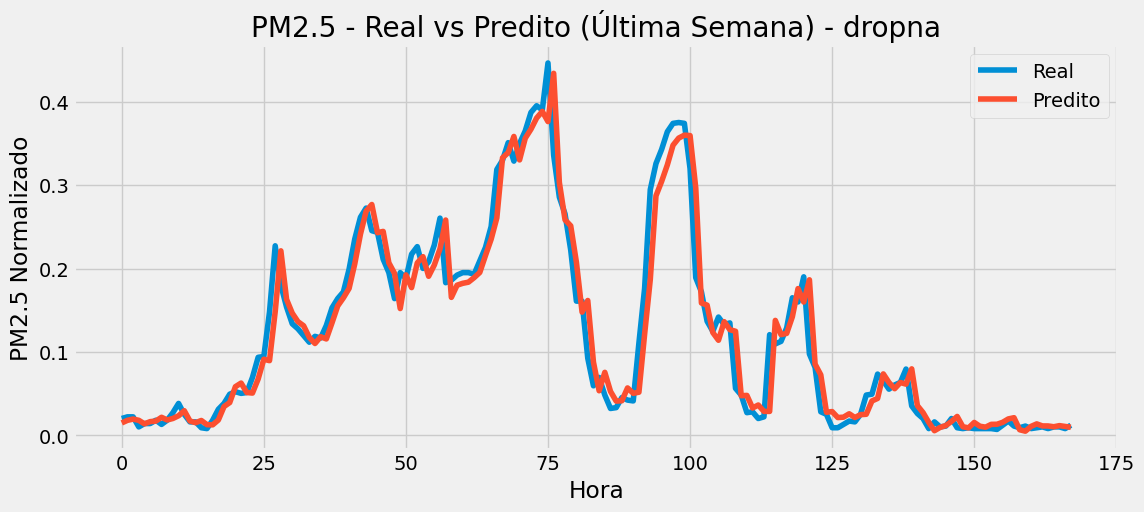

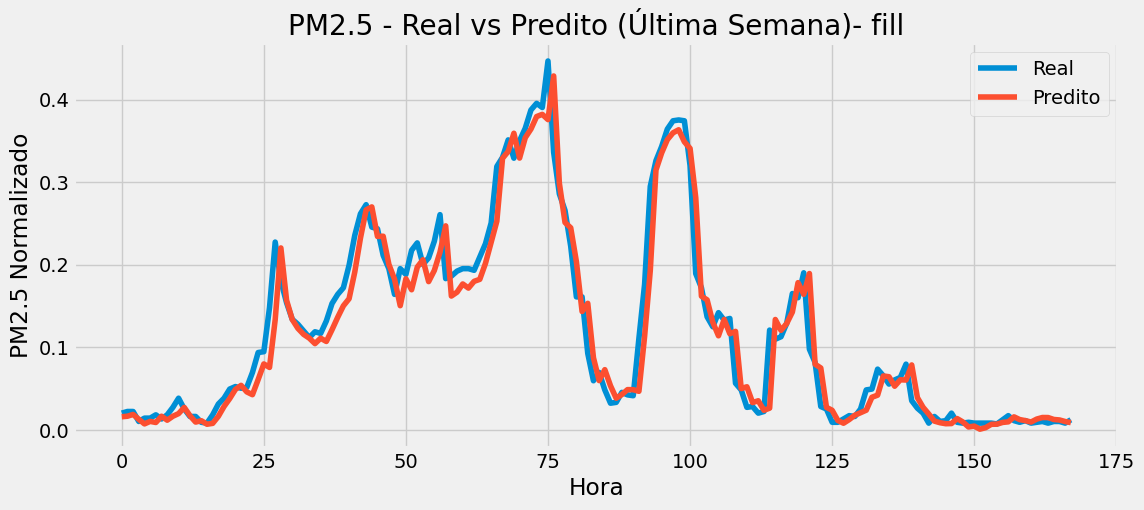

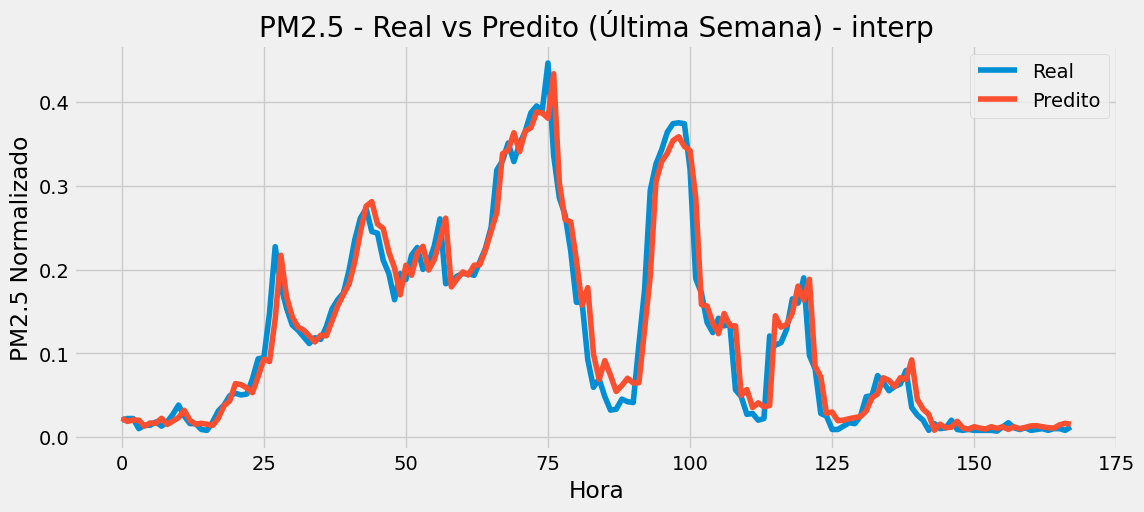

In [68]:
# Supondo dados horários: 24 * 7 = 168 amostras (última semana)
plt.figure(figsize=(12, 5))
plt.plot(y_dropna[-168:], label='Real')
plt.plot(y_pred_dropna[-168:], label='Predito')
plt.title("PM2.5 - Real vs Predito (Última Semana) - dropna")
plt.xlabel("Hora")
plt.ylabel("PM2.5 Normalizado")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_fill[-168:], label='Real')
plt.plot(y_pred_fill[-168:], label='Predito')
plt.title("PM2.5 - Real vs Predito (Última Semana)- fill")
plt.xlabel("Hora")
plt.ylabel("PM2.5 Normalizado")
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.plot(y_interp[-168:], label='Real')
plt.plot(y_pred_interp[-168:], label='Predito')
plt.title("PM2.5 - Real vs Predito (Última Semana) - interp")
plt.xlabel("Hora")
plt.ylabel("PM2.5 Normalizado")
plt.legend()
plt.show()


In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model_lstm = Sequential()
model_lstm.add(LSTM(units=64, activation='tanh', input_shape=(X_dropna.shape[1], X_dropna.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_lstm = model_lstm.fit(
    X_dropna, y_dropna,
    validation_split=0.2,
    epochs=20,
    batch_size=64,
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


522/522 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - loss: 0.0024 - mae: 0.0314 - val_loss: 6.0072e-04 - val_mae: 0.0148
Epoch 2/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 7.3815e-04 - mae: 0.0166 - val_loss: 4.7396e-04 - val_mae: 0.0126
Epoch 3/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 6.3464e-04 - mae: 0.0147 - val_loss: 6.3072e-04 - val_mae: 0.0172
Epoch 4/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - loss: 6.2925e-04 - mae: 0.0148 - val_loss: 4.5131e-04 - val_mae: 0.0119
Epoch 5/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 6.4759e-04 - mae: 0.0143 - val_loss: 4.6719e-04 - val_mae: 0.0126
Epoch 6/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 5.7991e-04 - mae: 0.0140 - val_loss: 4.6173e-04 - val_mae: 0.0121
Epoch 7/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 5.6549e-04 - mae: 0.0137 - val_loss: 5.1599e-04 - val_mae: 0.0137
Epoch 8/20
522/522 ━━━━━━━━━━━━━━━━━━━━ 20s 20ms/step - loss: 5.6150e-04 - mae: 0.0140 - val_loss: 4.6637e-04 - val_mae

In [ ]:
# Previsão
y_pred_lstm = model_lstm.predict(X_dropna)

# Avaliação
rmse_lstm = np.sqrt(mean_squared_error(y_dropna, y_pred_lstm))
mae_lstm = mean_absolute_error(y_dropna, y_pred_lstm)
r2_lstm = r2_score(y_dropna, y_pred_lstm)

print(f"LSTM - MAE: {mae_lstm:.4f}")
print(f"LSTM - RMSE: {rmse_lstm:.4f}")
print(f"LSTM - R²: {r2_lstm:.4f}")


plt.figure(figsize=(12, 5))
plt.plot(y_dropna[-168:], label='Real')
plt.plot(y_pred_lstm[-168:], label='Predito')
plt.title("PM2.5 - Real vs Predito (Última Semana) - LSTM")
plt.xlabel("Hora")
plt.ylabel("PM2.5 Normalizado")
plt.legend()
plt.show()
